# Prepare data for SKAT-O


using RVTESTS as this is all I can get to install on Iridis

In [1]:
import pandas as pd
import seaborn as sns
import sys
from bioinfokit import analys, visuz
sns.set()

In [2]:
# Load the full data
df_joined = pd.read_pickle("Data/all_vars_with_cadd_15_lowfreq_concordant.pickle")

## Use the list of PCA-ok samples here before splitting to cases and controls
samples_to_keep = pd.read_csv("Data/PCA-samples-to-use.txt", names=["MAT_ID"])
# Convert to a list so it's really simple to iterate over
keep_list = samples_to_keep.MAT_ID.to_list()

# Now try to actually use this...
print(f"{samples_to_keep.shape[0]} samples to keep.", file=sys.stderr)
print(f"{len(df_joined.MAT_ID.unique())} samples before trimming.", file=sys.stderr)

# How many times does the first MAT IF occur?
df_joined = df_joined[df_joined['MAT_ID'].isin(keep_list)]

# Check that the samples have been dropped
print(f"{len(df_joined.MAT_ID.unique())} samples after PCA trimming.", file=sys.stderr)

# Split cases and controls - use 3+ pregnancy losses as controls because 2 isn't as clearly recurrent
# TODO: Check to see how much difference this makes?
df_cases = df_joined[df_joined.pregnancy_loss_history == "3+"]
df_controls = df_joined[df_joined.pregnancy_loss_history == "None"]

ctrl_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["None"]
case_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["3+"]
discarded_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["2"]

print(f"Total number of cases: {case_count}", file=sys.stderr)
print(f"Total number of controls: {ctrl_count}", file=sys.stderr)
print(f"Discarded samples: {discarded_count}", file=sys.stderr)

1100 samples to keep.
1238 samples before trimming.
1100 samples after PCA trimming.
Total number of cases: 226
Total number of controls: 516
Discarded samples: 358


## Prepare phenotype .ped file

Export sample data (for cases and controls) into plink .ped format for use in RVTESTS. Correct .ped format is:

| Family ID | Individual ID | Maternal ID | Paternal ID | Sex | Phenotype |
|-----------|---------------|-------------|-------------|-----|-----------|
|  n/a      | Sample ID     | n/a         | n/a         | 2   | 1         |

Where phenotype may be either 1 (unaffected) or 2 (affected). Use 1 to indicated controls, 2 for cases.
2 for sex indicated female

In [3]:
fname = "Processed_data/phenotypes.ped"
with open(fname, "w") as f:
    # Write file header
    f.write("fid\tiid\tfatid\tmatid\tsex\ty1\n")
    # Write the cases to the output file
    df_cases.drop_duplicates(['MAT_ID']).apply(lambda x: f.write(f"{x['MAT_ID']}\t{x['MAT_ID']}\t0\t0\t2\t1\n"), axis=1)
    # Write the controls
    df_controls.drop_duplicates(['MAT_ID']).apply(lambda x: f.write(f"{x['MAT_ID']}\t{x['MAT_ID']}\t0\t0\t2\t2\n"), axis=1)

## Prepare covariates .ped file

The format is the same as for the phenotpye file, but with extra columns named so that they can be specified using the --covar-name option

**NOTE:** I don't seem to be able to get this to work - maybe the data we have isn't appropriate? With a covariates file the analysis doesn't produce any results.

Instead of using age, look up the PCA results and use that instead

In [4]:
def load_pca(pcadata: str) -> pd.DataFrame:
    """Load and process the data needed for PCA plots."""        
    # Load the PCA data (from plink eigenvalues file, with only the first 2 prinicpal components)
    # TODO: Check the eigenvectors file, which I think shows how much variation each principal component explains.
    #pca = pd.read_csv("Data/PLINK.DDD-and-1KGP-phase1.pca.plot", sep="\t", names=["ID", "PC1", "PC2"], index_col="ID")
    pca = pd.read_csv(pcadata,
                      sep=" ",
                      names=["ID", "ID2", "PC1", "PC2", "PC3", "PC4",
                             "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
                             "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", 
                             "PC17", "PC18", "PC19", "PC20"],
                      index_col="ID")

    # TEMP: For 1kgp testing, correct the ID column
    pca['ID'] = pca.ID2.map(lambda x: x.split("_")[0])
    #pca.set_index('ID', inplace=True)
    #pca.drop("ID2", axis=1, inplace=True)
    
    return pca

pca = load_pca("Data/AC10-in-both.AUTOSOMES-ONLY/PLINK.pca.eigenvec")
pca = pca[pca.ID2.isin(keep_list)]

pca.head()

ID2       PC1       PC2       PC3       PC4       PC5  \
ID                                                                         
DDDP100035  DDDP100035 -0.013135 -0.004308 -0.008689 -0.004515  0.001784   
DDDP100053  DDDP100053 -0.015510 -0.006054 -0.000915  0.004441  0.024431   
DDDP100066  DDDP100066 -0.011579 -0.003971 -0.001243 -0.012968  0.036228   
DDDP100096  DDDP100096 -0.013788 -0.006041 -0.007730  0.002501  0.045486   
DDDP100104  DDDP100104 -0.012757 -0.006328 -0.005834  0.002606 -0.016882   

                 PC6       PC7       PC8       PC9  ...      PC12      PC13  \
ID                                                  ...                       
DDDP100035  0.004432 -0.003745  0.001519  0.001406  ...  0.001681 -0.007999   
DDDP100053 -0.007836  0.001290 -0.023461  0.006013  ... -0.019617 -0.006024   
DDDP100066 -0.027430  0.014288  0.004141  0.010263  ... -0.005643  0.010883   
DDDP100096 -0.005980  0.011328 -0.010147  0.001940  ... -0.009924  0.018890   
DDDP100104 -0.002823  0.003449  0.001808  0.001956  ...  0.016461 -0.020850   

                PC14      PC15      PC16      PC17      PC18      PC19  \
ID                                                                       
DDDP100035  0.014709  0.002984 -0.040739 -0.009962 -0.009361 -0.007139   
DDDP100053 -0.024324 -0.019178 -0.006217  0.005254  0.002850  0.029687   
DDDP100066  0.008817 -0.018890 -0.007429 -0.004218  0.006822 -0.029282   
DDDP100096  0.004614 -0.038207 -0.060594 -0.014211 -0.012244 -0.017892   
DDDP100104  0.011359 -0.013233  0.005130 -0.007091  0.005458  0.039201   

                PC20          ID  
ID                                
DDDP100035 -0.009680  DDDP100035  
DDDP100053  0.024402  DDDP100053  
DDDP100066  0.010633  DDDP100066  
DDDP100096  0.003451  DDDP100096  
DDDP100104  0.001604  DDDP100104  

[5 rows x 22 columns]

In [5]:
# Load the full data file
df_full = pd.read_pickle("Data/full_variant_data_with_CADD.pickle")

In [6]:
## TODO: Age has missing values ("nan") in a format that RVTESTS doesn't like. Replace with "NA" and it seems to work.

# Remove all duplicates - get just one row per sample
df_cov = df_full.drop_duplicates("MAT_ID")
# Get just the target files
df_cov = df_cov[df_cov['MAT_ID'].isin(keep_list)]
# Remove all the variant data (i.e. non-phenotype stuff)
df_cov = df_cov[["MAT_ID", "pregnancy_loss_history", "mothers_age", "similar_phenotype_mother", "fathers_age", "similar_phenotype_father", "only_patient_affected", "consanguinity", "assisted_reproduction", "multiple_births", "maternal_illness"]]

# Pick and choose the best columns for covariates and apply numerical values where appropriate.
# Replace consanguinity values with numbers
df_cov.consanguinity = df_cov.consanguinity.replace(['Yes', 'No', 'Unknown'],[0, 1, 2])
df_cov.assisted_reproduction = df_cov.assisted_reproduction.replace(['Yes', 'No', 'Unknown'],[0, 1, 2])

df_cov = df_cov.set_index("MAT_ID")

pca = pca.merge(df_cov, left_index=True, right_index=True)

In [7]:
pca.head()

ID2       PC1       PC2       PC3       PC4       PC5  \
DDDP100035  DDDP100035 -0.013135 -0.004308 -0.008689 -0.004515  0.001784   
DDDP100053  DDDP100053 -0.015510 -0.006054 -0.000915  0.004441  0.024431   
DDDP100066  DDDP100066 -0.011579 -0.003971 -0.001243 -0.012968  0.036228   
DDDP100096  DDDP100096 -0.013788 -0.006041 -0.007730  0.002501  0.045486   
DDDP100104  DDDP100104 -0.012757 -0.006328 -0.005834  0.002606 -0.016882   

                 PC6       PC7       PC8       PC9  ...  \
DDDP100035  0.004432 -0.003745  0.001519  0.001406  ...   
DDDP100053 -0.007836  0.001290 -0.023461  0.006013  ...   
DDDP100066 -0.027430  0.014288  0.004141  0.010263  ...   
DDDP100096 -0.005980  0.011328 -0.010147  0.001940  ...   
DDDP100104 -0.002823  0.003449  0.001808  0.001956  ...   

            pregnancy_loss_history  mothers_age  similar_phenotype_mother  \
DDDP100035                    None         28.0                unaffected   
DDDP100053                       2         36.0                unaffected   
DDDP100066                    None         34.0                unaffected   
DDDP100096                    None         38.0                unaffected   
DDDP100104                      3+         40.0                unaffected   

            fathers_age  similar_phenotype_father  only_patient_affected  \
DDDP100035           28                unaffected                     No   
DDDP100053           35                unaffected                    Yes   
DDDP100066           48                unaffected                     No   
DDDP100096           37                unaffected                     No   
DDDP100104           40                unaffected                    Yes   

            consanguinity  assisted_reproduction  multiple_births  \
DDDP100035              1                      1        Singleton   
DDDP100053              1                      1        Singleton   
DDDP100066              1                      1        Singleton   
DDDP100096              1                      1        Singleton   
DDDP100104              1                      1        Singleton   

            maternal_illness  
DDDP100035                No  
DDDP100053                No  
DDDP100066               Yes  
DDDP100096                No  
DDDP100104               Yes  

[5 rows x 32 columns]

In [8]:
fname = "Processed_data/covariates.ped"
with open(fname, "w") as f:
    # Write file header
    # y1, y2, y3, etc. are the covariates.
    # Change to a descriptive name and update rvtests --covar-name list
    f.write("fid\tiid\tage\tconsanguinity\tpc1\tpc2\tpc3\tpc4\tpc5\n")
    # Write the cases to the output file
    pca.apply(lambda x: f.write(f"{x['ID2']}\t{x['ID2']}\t{x['mothers_age']}\t{x['consanguinity']}\t{x['PC1']}\t{x['PC2']}\t{x['PC3']}\t{x['PC4']}\t{x['PC5']}\n"), axis=1)

## List of variants to retain

VCFs will be merged separately, but we only want to retain the variants which have past previous filtering (i.e. the ones we used for the burden test). To do this, we can ouput a list of all those variants in a basic VCF format. Then that can be used with vcflib (I think) to keep only those varaints from the merged VCF. This can then be used to run RVTESTS SKAT-O.

In [9]:
# This can (maybe) be improved?
# get the list of genes which have at least one variant in a case, and restrict varaint output to juts those genes.
# If the number is lower, it might allow for a correction to be applied?
df_joined = pd.read_pickle("Data/all_vars_with_cadd_15_lowfreq_concordant.pickle")
df_joined.head()

GENE           ID      MAT_ID  MAT_COUNT pregnancy_loss_history
573413  SAMD11  1:878644G>A  DDDP116216          1                      2
573624   NOC2L  1:892538C>T  DDDP100126          1                   None
574248  KLHL17  1:897398G>A  DDDP122130          1                   None
574250  KLHL17  1:897831C>T  DDDP101794          1                   None
574251  KLHL17  1:898153C>A  DDDP128574          1                      2

In [10]:
df_unique = df_joined.drop_duplicates("ID")

df_unique.loc[:,'CHROM'] = df_unique.ID.apply(lambda x: x.split(":")[0])
df_unique.loc[:,'POS'] = df_unique.ID.apply(lambda x: int(''.join([y for y in x.split(":")[1].split(">")[0] if y.isdigit()])))
df_unique.loc[:,'REF'] = df_unique.ID.apply(lambda x: ''.join([y for y in x.split(":")[1].split(">")[0] if not y.isdigit()]))
df_unique.loc[:,'ALT'] = df_unique.ID.apply(lambda x: x.split(">")[1])

df_unique = df_unique[["ID", "CHROM", "POS", "REF", "ALT", "GENE"]]

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
fname = "Processed_data/variants_to_keep.vcf"
with open(fname, "w") as f:
    f.write("##fileformat=VCFv4.2\n")
    f.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n")
    df_unique.apply(lambda x: f.write(f"{x['CHROM']}\t{x['POS']}\t.\t{x['REF']}\t{x['ALT']}\t99\tPASS\tGENE={x['GENE']}\n"), axis=1)

## Interpret results

Compare the results - burden, SKAT, and SKAT-O

In [12]:
# First, look at the Fisher Exact test - does it match my manual version?
df_cmc_exact = pd.read_csv("Data/FINAL/RVTESTS.FINAL.variants_for_SKATO.variants_only.CMCFisherExact.assoc", delimiter="\t")
df_cmc_exact = df_cmc_exact.sort_values("PvalueLess", ascending=True)
df_cmc_exact.head()

Gene                                    RANGE  N_INFORMATIVE  \
6977      SELO                     22:50639407-50656045            742   
4346    INO80E                     16:30007530-30017112            742   
4238   CARHSP1    16:8946801-8962863,16:8946801-8962248            742   
4378  C16orf62                     16:19566736-19712485            742   
717       POMC  2:25383721-25391559,2:25383721-25391559            742   

      NumVar  NumPolyVar  N00  N01  N10  N11  PvalueTwoSide  PvalueLess  \
6977       3           3  213  510   13    6       0.000619    0.000619   
4346       2           2  220  516    6    0       0.000762    0.000762   
4238       1           1  221  516    5    0       0.002541    0.002541   
4378       4           4  216  511   10    5       0.003788    0.003788   
717        4           4  216  511   10    5       0.003788    0.003788   

      PvalueGreater  
6977       0.999894  
4346       1.000000  
4238       1.000000  
4378       0.999314  
717        0.999314

For the 5 examples shown above, the RVTESTS CMC Fisher Exact methods gives the same results as for my burden test - this makes sense as it should be the same method, and was run on the same variants (the exact list was taken from the dataframe used for burden testing, and used to pull those same variants from the merged VCF of all target samples).

The column N10 represents the number of case samples with variants

In [13]:
print(f"Genes with 0 cases with variants: {df_cmc_exact[df_cmc_exact.N10 == 0].shape[0]}", file=sys.stderr)
print(f"Genes with >=1 cases with variants: {df_cmc_exact[df_cmc_exact.N10 != 0].shape[0]}", file=sys.stderr)
print(f"Genes with >=5 cases with variants: {df_cmc_exact[df_cmc_exact.N10 >= 5].shape[0]}", file=sys.stderr)
print(f"Genes with >=10 cases with variants: {df_cmc_exact[df_cmc_exact.N10 >= 10].shape[0]}", file=sys.stderr)

Genes with 0 cases with variants: 3681
Genes with >=1 cases with variants: 6439
Genes with >=5 cases with variants: 1089
Genes with >=10 cases with variants: 230


We can discard the genes with 0 case variants, as they provide no useful information. This leaves 6439 genes on which an informative test was carried out, and therefore gives the number of tests that should be used for any corrections applied to these results.

If we require a minimum number of cases with variants to define an "informative" test, assuming that fewer cases are more likely to skew either way purely by chance, we can reduce the number of tests. If we set 5 as a minimum number of cases with variants, then the Bonferonni corrected p value becomes 0.05/1089 = 0.000046. This still leaves no significant results. If we set the bar even higher, and require a minimum of 10 cases with variants then the corrected p value is 0.05/230~= 0.000217. This is very close to the p value of SELO, but is almost certainly an inappropriate cherry-picking of the data.

In [14]:
#df_skato = pd.read_csv("Data/FINAL/RVTESTS.FINAL.variants_for_SKATO.variants_only.SkatO.assoc", delimiter="\t")
df_skato = pd.read_csv("Data/COVARIATES3.RVTESTS.FINAL.variants_for_SKATO/COVARIATES3.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc", delimiter="\t")

df_skato = df_skato.sort_values("Pvalue", ascending=True)
df_skato.head(10)

df_cmc_exact[df_cmc_exact.Gene == "TLE6"]

Gene                                  RANGE  N_INFORMATIVE  NumVar  \
5310  TLE6  19:2977535-2995182,19:2977535-2995182            742       1   

      NumPolyVar  N00  N01  N10  N11  PvalueTwoSide  PvalueLess  PvalueGreater  
5310           1  225  516    1    0       0.304582    0.304582            1.0

The SKAT-O test from RVTESTS, as detailed above, have no significant results when corrected for multiple testing. However, the most significant results are from genes which have at least a plausible method of action.

*SELO* is a mitochondrial gene, and although located on chromosome 22, could possibly be affecting mitochondria present at the very earliest stages of embronic development.

*INO80E* is a component of a chromatin remodelling complex, and is thought to be involved in DNA replication, repair, and transcriptional regulation.

*CARHSP1* is possibly associated with the disease Thrombocytopenia-absent radius syndrome, and is associated with binding single-stranded RNA and DNA.

*XKR9* may be assocaited with branchiootorenal syndrome, which includes birth defects with ear and kidney malformations

*AHNAK* has a function in cell migration, and so may be important developmentally.

*RHOT1* is a mitochondrial GTPase

*POMC* is associated with red hair pigmentation, which is not generally considered a disease.

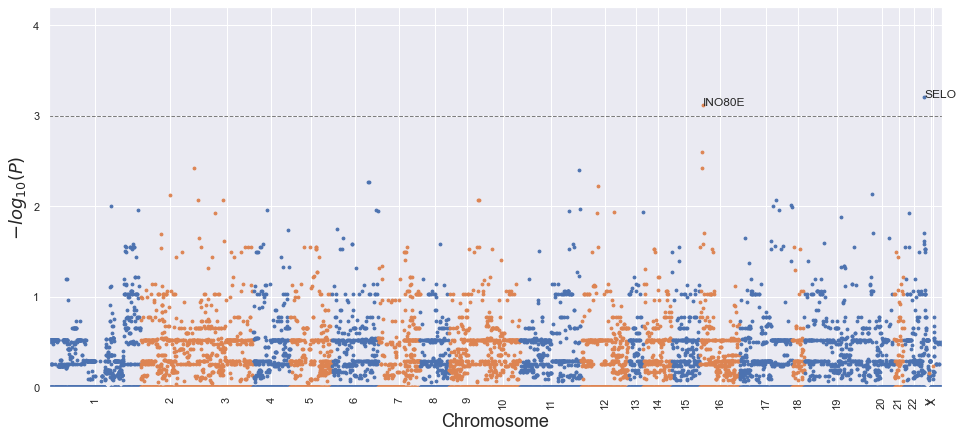

In [15]:
# Manhattan plots - burden vs. SKAT-O
def extract_chr(gene):
    return gene.RANGE.split(":")[0].split("_")[0]

df_cmc_exact.loc[:,'CHR'] = df_cmc_exact.apply(extract_chr, axis=1)

color = (sns.color_palette()[0], sns.color_palette()[1])
pval_threshold = 0.001
ax1 = visuz.marker.mhat(df = df_cmc_exact,
                        chr = 'CHR',
                        pv = 'PvalueTwoSide',
                        show = True,
                        dim = (16,7),
                        color = color,
                        gwas_sign_line = True,
                        gwasp = pval_threshold,
                        markeridcol = 'Gene',
                        markernames = True,
                        gfont = 12,
                        axlabelfontsize = 18,
                        axxlabel = "Chromosome")

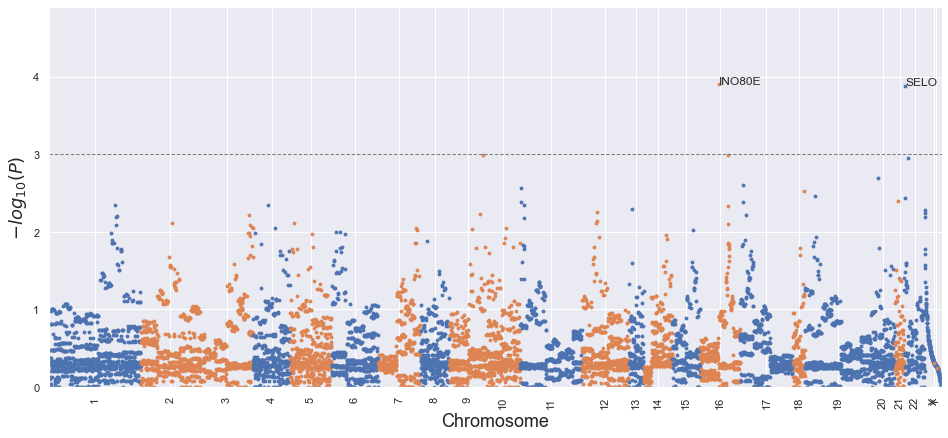

In [16]:
df_skato.loc[:,'CHR'] = df_skato.apply(extract_chr, axis=1)

color = (sns.color_palette()[0], sns.color_palette()[1])
pval_threshold = 0.001
ax1 = visuz.marker.mhat(df = df_skato,
                        chr = 'CHR',
                        pv = 'Pvalue',
                        show = True,
                        dim = (16,7),
                        color = color,
                        gwas_sign_line = True,
                        gwasp = pval_threshold,
                        markeridcol = 'Gene',
                        markernames = True,
                        gfont = 12,
                        axlabelfontsize = 18,
                        axxlabel = "Chromosome")

## Random phenotype

If we assign phenotype randomly, how many significant results will occur? This might help to indicate to what extent we need to correct the results. Multiple repeats as a kind of bootstapping might be useful?

In [17]:
df_random = df_joined[df_joined.pregnancy_loss_history != "2"]
df_random = df_random.drop_duplicates(['MAT_ID'])

# TODO: what are the correct ratios?

df_cases = df_random.sample(frac=0.25)
df_controls = df_random.drop(df_cases.index)

fname = "Processed_data/phenotypes.RANDOM.ped"
with open(fname, "w") as f:
    # Write file header
    f.write("fid\tiid\tfatid\tmatid\tsex\ty1\n")
    # Write the cases to the output file
    df_cases.apply(lambda x: f.write(f"{x['MAT_ID']}\t{x['MAT_ID']}\t0\t0\t2\t1\n"), axis=1)
    # Write the controls
    df_controls.apply(lambda x: f.write(f"{x['MAT_ID']}\t{x['MAT_ID']}\t0\t0\t2\t2\n"), axis=1)

In [18]:
def count_significant(path, sig):
    # Load the CMCFisherExact results, as this contains the number of cases with variants
    df_temp = pd.read_csv(path.replace("SkatO", "CMCFisherExact"), delimiter="\t")
    # Find the number of tests (e.g. number of genes with at least one variant)
    tests = df_temp[df_temp.N10 != 0].shape[0]
    # Adjust the p-value (Bonferonni correction)
    adj_sig = sig / tests
    
    df_temp = pd.read_csv(path, delimiter="\t")
    return (df_temp[df_temp.Pvalue <= sig].shape[0], adj_sig, df_temp[df_temp.Pvalue <= adj_sig].shape[0])


print(f"REAL: {count_significant('Data/FINAL/RVTESTS.FINAL.variants_for_SKATO.variants_only.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 01: {count_significant('Data/RANDOM01/RANDOM01.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 02: {count_significant('Data/RANDOM02/RANDOM02.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 03: {count_significant('Data/RANDOM03/RANDOM03.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 04: {count_significant('Data/RANDOM04/RANDOM04.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 05: {count_significant('Data/RANDOM05/RANDOM05.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

print(f"RANDOM 06: {count_significant('Data/RANDOM06/RANDOM06.RVTESTS.FINAL.variants_for_SKATO.SkatO.assoc', 0.05)}", file=sys.stderr)

REAL: (346, 7.76518092871564e-06, 0)
RANDOM 01: (305, 8.44451950684006e-06, 0)
RANDOM 02: (348, 8.305647840531562e-06, 0)
RANDOM 03: (322, 8.35421888053467e-06, 0)
RANDOM 04: (365, 8.514986376021799e-06, 0)
RANDOM 05: (332, 8.430281571404485e-06, 0)
RANDOM 06: (305, 8.542627712284299e-06, 0)


## Gene list for GSEA

In [19]:
df_skato[df_skato.Pvalue <= 0.05].Gene.to_csv("Processed_data/SKAT-O_significant_genes.txt", sep="\t", header=False, index=False)

df_skato.Gene.to_csv("Processed_data/SKAT-O_all_genes.txt", header=False, index=False)

## Candidate gene list

From Deborah way back at the start

**TODO:** See if there are any more viable genes in the literature...

In [20]:
genes=["NLRP5","PADI6","NLRP14","DNMT1","TLE6","AKAP9","UHRF1","NLRP4","RDX","EEF1A1","ARHGEF2","NLRP7",
       "PYDC2","NLRP2","YWHAZ","DDB1","RHPN2","OOEP","USP9X","NLRP4","YWHAG","DDX6","YWHAH","YWHAQ","NLRP4",
       "YWHAE","DDX19A","DNMT1","ZAR1","DDX3X","DDX3Y","NLRP4","PDIA6","CDC42","CDCA2","CDK19","CDK5","MSN",
       "NLRP9"]

#df_joined = df_joined[df_joined['MAT_ID'].isin(keep_list)]
df_skato[df_skato['Gene'].isin(genes)].head()

Gene                                              RANGE  \
3373  ARHGEF2  1:155916629-155947966,1:155916629-155948336,1:...   
5310     TLE6              19:2977535-2995182,19:2977535-2995182   
3114    CDCA2                                8:25316512-25365425   
7408    PYDC2                              3:191178951-191179245   
4684    AKAP9            7:91570188-91739987,7:91570188-91739987   

      N_INFORMATIVE  NumVar  NumPolyVar          Q  rho    Pvalue CHR  \
3373            698       2           2   743.7550  1.0  0.010422   1   
5310            698       1           1   154.5160  0.0  0.112255  19   
3114            698       4           4  1146.7000  0.9  0.228572   8   
7408            698       1           1    96.5728  0.0  0.249377   3   
4684            698       7           7  1257.6400  1.0  0.306740   7   

         tpval  
3373  1.982053  
5310  0.949794  
3114  0.640977  
7408  0.603144  
4684  0.513230